# Collaborative Filtering Neaural Network

In [327]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing

from tensorflow.keras import models, layers, utils  

# Loading Data

In [328]:
## load movies data
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [329]:
## load user ratings data
users = pd.read_csv("data/ratings.csv")
users.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Data Cleaning

In [330]:
## Movies

## assign new movie id to "movie"
movies["movie"] = range(0,len(movies))

## extract the movie's name from the "title" column
movies["name"] = movies["title"].str.split(r"(").str[0]

## extract the movie's year from the "title" column
movies["year"] = movies["title"].apply(lambda x: int(x.split(r"(")[-1][0:4]) if r"(" in x else np.nan)

## new feature: "old" is True if year is < 2000, o/w False
movies["old"] = movies["year"].apply(lambda x: 1 if x < 2000 else 0)
movies.head()

,movieId,title,genres,movie,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1


In [331]:
## Users

## scale new user id starting at 0 and assign to "user"
users["user"] = users["userId"].apply(lambda x: x-1)

## converting timestamp int into Timestamp
users["timestamp"] = users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

## flagging if timestamp is during the daytime
users["daytime"] = users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

## flagging if timestamp is on the weekend
users["weekend"] = users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

## adding new movie id column "movie" to users df
users = users.merge(movies[["movieId","movie"]], how="left")

## rename "rating" to "y" (this is our target variable)
users = users.rename(columns={"rating":"y"})

In [332]:
## clean movies
movies = movies[["movie","name","old","genres"]].set_index("movie")
movies.head()

,name,old,genres
movie,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [333]:
## clean users
users = users[["user","movie","daytime","weekend","y"]]
users.head()

,user,movie,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


In [334]:
## saving other features into context if needed later
context = users[["user","movie","daytime","weekend"]]
context.head()

,user,movie,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [335]:
## One-Hot-Encode genres
genres = list(movies["genres"].str.split(r"|"))
temp = genres[0]
for i in range(1, len(genres)):
    temp.extend(genres[i])

new_cols = list(set(temp))
new_cols.remove("(no genres listed)")
for col in new_cols:
    movies[col] = movies["genres"].str.contains(col).astype(int)
movies.head()

,name,old,genres,Comedy,Thriller,Documentary,Film-Noir,Children,War,Musical,...,Romance,Western,Drama,Crime,Horror,Action,Sci-Fi,IMAX,Animation,Mystery
movie,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Jumanji,1,Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,Father of the Bride Part II,1,Comedy,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Understaning the Data

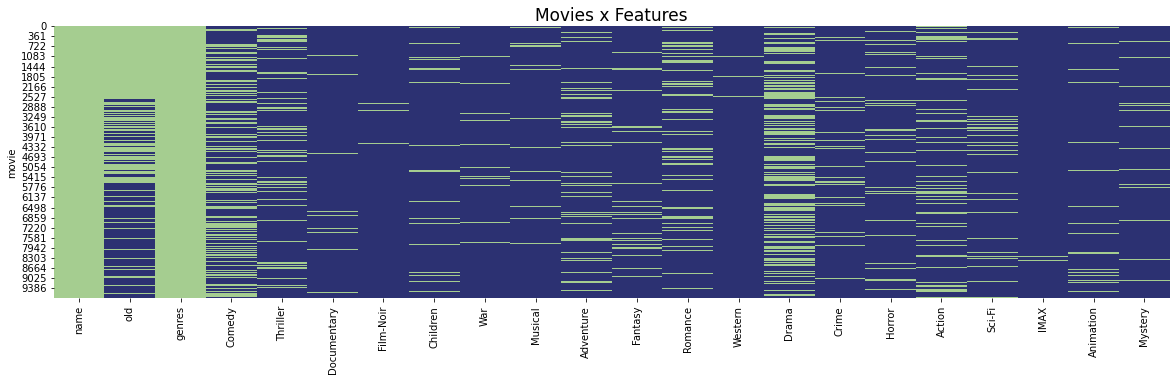

In [336]:
## heatmap: Movies x Features
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies==0, vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Movies x Features", size=17)
plt.show()

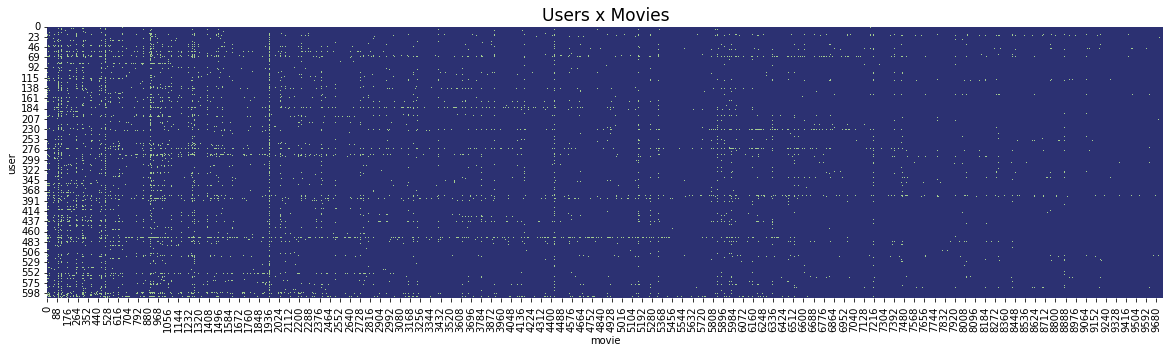

In [337]:
## One-Hot-Encode users X movie data
## 1 if user gave movie a rating o/w 0
users_tmp = users.copy()
users_tmp["y_binary"] = 1
users_pivot = users_tmp.pivot(index="user", columns="movie", values="y_binary")

missing_cols = list(set(movies.index) - set(users_pivot.columns))
for col in missing_cols:
    users_pivot[col] = np.nan
   
users_pivot.replace(np.nan, 0, inplace=True)
users_pivot = users_pivot[sorted(users_pivot.columns)]
users_pivot

## heatmap: Users X Movies
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(users_pivot==0, vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Users x Movies", size=17)
plt.show()

In [322]:
users

movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
